In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")
    
import pickle

In [3]:
from src.dataloader import *
from src.models import *
from src.trainer import *
from src.utils import *
from src.evaluation import *
from src.regrid import *

In [4]:
DATADRIVE = '/home/jupyter/data/'

## Load datasets

In [12]:
# # Using first few days of every month of 2020, eventually use all of 2020
ds_test = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2020-01', '2020-12'),
    scale=False,
    first_days=5,
)

/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [13]:
# # Using first few days of every month of 2020, eventually use all of 2020
ds_test_ens = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation_ens10'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2020-01', '2020-12'),
    scale=False,
    first_days=5,
)

/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


## Get mask

In [14]:
ds = xr.open_dataset(
    '/home/jupyter/data/hrrr/raw/total_precipitation/20180215_00.nc')

In [15]:
ds_regridded = regrid(ds, 4, lons=(235, 290), lats=(50, 20))[0]

Creating new regridder


/opt/conda/envs/ilan/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [16]:
hrrr_mask = np.isfinite(ds_regridded).tp.isel(init_time=0, lead_time=0)

In [17]:
rq = xr.open_dataarray(f'{DATADRIVE}/mrms/4km/RadarQuality.nc')
mrms_mask = rq>-1
mrms_mask = mrms_mask.assign_coords({
    'lat': hrrr_mask.lat,
    'lon': hrrr_mask.lon
})

In [18]:
total_mask = mrms_mask * hrrr_mask

In [19]:
# total_mask = total_mask.isel(lat=slice(0, -6))

In [20]:
total_mask = total_mask.assign_coords({'lat': ds_test.mrms.lat.values, 'lon': ds_test.mrms.lon.values})

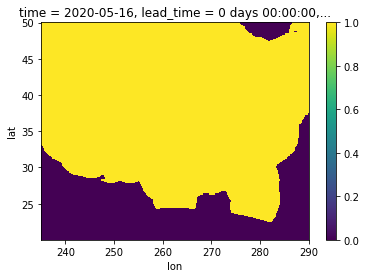

In [21]:
total_mask.plot()

## MRMS

In [50]:
mrms = ds_test.mrms.rename({'time': 'valid_time'}).where(total_mask)

In [53]:
mrms = mrms.isel(valid_time=slice(2, None))

## Interpolation baseline

In [24]:
tigge = ds_test.tigge.isel(variable=0)
tigge_ens = ds_test_ens.tigge.isel(variable=0)

In [25]:
interp = tigge.interp_like(mrms, method='linear').where(total_mask)
interp_ens = tigge_ens.interp_like(mrms, method='linear').where(total_mask)

In [26]:
# To match HREF valid times
interp = interp.isel(valid_time=slice(1, None))
interp_ens = interp_ens.isel(valid_time=slice(1, None))

## HRRR baseline

In [33]:
fn = f'{DATADRIVE}/hrrr/4km/total_precipitation/2020*.nc'
hrrr = xr.open_mfdataset(fn)

In [34]:
hrrr = hrrr.tp.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h'))

In [35]:
hrrr['valid_time'] = hrrr.init_time + hrrr.lead_time
hrrr = hrrr.swap_dims({'init_time': 'valid_time'})

In [36]:
hrrr = hrrr.assign_coords({'lat': interp.lat.values, 'lon': interp.lon.values})

In [37]:
hrrr = hrrr.sel(valid_time=interp.valid_time).where(total_mask)

In [38]:
hrrr.load()

<xarray.DataArray 'tp' (valid_time: 108, lat: 750, lon: 1376)>
array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[1.1901429e+00, 1.9800528e+00, 2.6092391e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [4.1386466e+00, 3.9645858e+00, 3.7803135e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [5.4436865e+00, 5.1828141e+00, 4.8884931e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
...
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]]], dtype=float32)
Coordinates:
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * valid_time  (valid_time) datetime64[ns] 2020-01-02T12:00:00 ... 2020-12-0...
    variable    <U2 'tp'
    time        datetime64[ns] 2020-05-16

## HREF baseline

In [39]:
href = xr.open_mfdataset('/home/jupyter/data//href/4km/total_precipitation/2020*.nc')

In [40]:
href = href.tp.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h'))

In [41]:
href['valid_time'] = href.init_time + href.lead_time
href = href.swap_dims({'init_time': 'valid_time'})

In [42]:
href = href.assign_coords({'lat': interp.lat.values, 'lon': interp.lon.values})

In [43]:
href = href.sel(valid_time=interp.valid_time).where(total_mask)

In [44]:
href.load()

<xarray.DataArray 'tp' (member: 10, valid_time: 108, lat: 750, lon: 1376)>
array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[ 2.00601816e+00,  2.00601816e+00,  2.00601816e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 2.64872050e+00,  2.07739806e+00,  2.00601816e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 3.44356441e+00,  3.17890978e+00,  2.89573479e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
...
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           5.66494823e-01,  2.96952367e-01,  1.26129150e-01],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           3.26510429e-01,  2.67808676e-01,  2.60011911e-01],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           1.82678461e-01,  1.94554806e-01,  2.18770266e-01],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]],
      dtype=float32)
Coordinates:
    surface     float64 0.0
  * valid_time  (valid_time) datetime64[ns] 2020-01-02T12:00:00 ... 2020-12-0...
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * member      (member) object 'hiresw_conusarw' ... 'hrrr-12h'
    variable    <U2 'tp'

## Save intermediate arrays

In [45]:
!mkdir -p tmp

In [54]:
mrms.to_netcdf('tmp/mrms.nc')
interp.to_netcdf('tmp/interp.nc')
interp_ens.to_netcdf('tmp/interp_ens.nc')
hrrr.to_netcdf('tmp/hrrr.nc')
href.to_netcdf('tmp/href.nc')

## Compute scores

### Mean RMSE

In [55]:
xs.rmse(interp, mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values

array(2.16683612)

In [56]:
xs.rmse(hrrr, mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values

array(3.0638828, dtype=float32)

In [57]:
xs.rmse(interp_ens.mean('member'), mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values

array(2.04700952)

In [58]:
xs.rmse(href.mean('member'), mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values

array(2.2253983, dtype=float32)

### CRPS

In [59]:
xs.crps_ensemble(mrms, interp_ens, dim=['lat', 'lon', 'valid_time']).values

array(0.37470519)

In [60]:
xs.crps_ensemble(mrms, href, dim=['lat', 'lon', 'valid_time']).values

array(0.38787542)

### Reliability diagram

In [64]:
mrms.

<xarray.DataArray 'tp' (valid_time: 108, lat: 750, lon: 1376)>
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.4375    , 0.55625004, 0.6437501 , ..., 0.        ,
         0.        , 0.        ],
        [0.79999995, 0.78125006, 0.95625   , ..., 0.        ,
         0.        , 0.        ],
        [1.0500001 , 1.        , 1.09375   , ..., 0.        ,
         0.        , 0.        ],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2020-01-02T12:00:00 ... 2020-12-0...
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
    time        datetime64[ns] 2020-05-16
    lead_time   timedelta64[ns] 00:00:00
    init_time   datetime64[ns] 2018-02-15

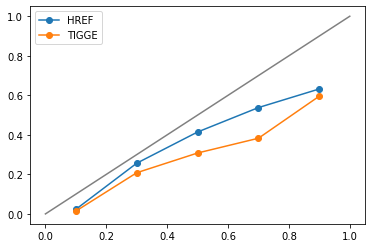

In [74]:
threshold = 1
rel_href = xs.reliability(mrms>threshold, (href>threshold).mean('member'))
rel_interp = xs.reliability(mrms>threshold, (interp_ens>threshold).mean('member'))
plt.plot([0, 1], [0, 1], c='gray')
plt.plot(rel_href.forecast_probability, rel_href, marker='o', label='HREF')
plt.plot(rel_interp.forecast_probability, rel_interp, marker='o', label='TIGGE')
plt.legend()

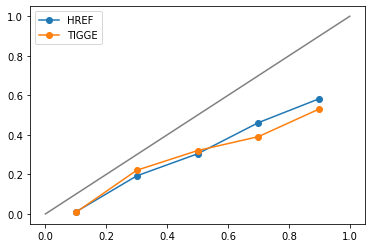

In [75]:
threshold = 5
rel_href = xs.reliability(mrms>threshold, (href>threshold).mean('member'))
rel_interp = xs.reliability(mrms>threshold, (interp_ens>threshold).mean('member'))
plt.plot([0, 1], [0, 1], c='gray')
plt.plot(rel_href.forecast_probability, rel_href, marker='o', label='HREF')
plt.plot(rel_interp.forecast_probability, rel_interp, marker='o', label='TIGGE')
plt.legend()

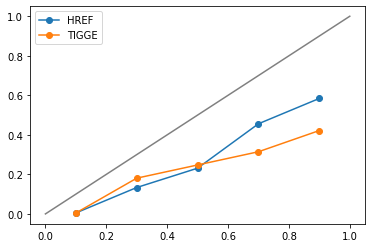

In [82]:
threshold = 10
rel_href = xs.reliability(mrms>threshold, (href>threshold).mean('member'))
rel_interp = xs.reliability(mrms>threshold, (interp_ens>threshold).mean('member'))
plt.plot([0, 1], [0, 1], c='gray')
plt.plot(rel_href.forecast_probability, rel_href, marker='o', label='HREF')
plt.plot(rel_interp.forecast_probability, rel_interp, marker='o', label='TIGGE')
plt.legend()

## Brier score

In [76]:
threshold = 1
xs.brier_score(mrms>threshold, (href>threshold).mean('member'), dim=['lat', 'lon', 'valid_time']).values

array(0.04253296)

In [77]:
threshold = 1
xs.brier_score(mrms>threshold, (interp_ens>threshold).mean('member'), dim=['lat', 'lon', 'valid_time']).values

array(0.04162999)

In [78]:
threshold = 5
xs.brier_score(mrms>threshold, (href>threshold).mean('member'), dim=['lat', 'lon', 'valid_time']).values

array(0.01613478)

In [79]:
threshold = 5
xs.brier_score(mrms>threshold, (interp_ens>threshold).mean('member'), dim=['lat', 'lon', 'valid_time']).values

array(0.01572524)

In [80]:
threshold = 10
xs.brier_score(mrms>threshold, (href>threshold).mean('member'), dim=['lat', 'lon', 'valid_time']).values

array(0.00733551)

In [81]:
threshold = 10
xs.brier_score(mrms>threshold, (interp_ens>threshold).mean('member'), dim=['lat', 'lon', 'valid_time']).values

array(0.00759274)

### Thresholded RMSE

In [ ]:
def thresh_rmse(a, b, thresh):
    a_thresh = a > thresh
    b_thresh = b > thresh
    

In [7]:
rq = xr.open_dataarray('/datadrive_ssd/mrms/4km/RadarQuality.nc')
eval_mask = rq>-1
fn = "/datadrive_ssd/mrms/4km/RadarOnly_QPE_06H/RadarOnly_QPE_06H_00.00_20180101-000000.nc"
ds = xr.open_dataset(fn)
assert eval_mask.lat.shape ==ds.lat.shape
eval_mask['lat'] = ds.lat 
assert eval_mask.lon.shape ==ds.lon.shape
eval_mask['lon'] = ds.lon

In [8]:
mrms = ds_test.mrms.rename(
    {'time': 'valid_time'})
mrms = mrms.where(eval_mask)

In [9]:
tigge = ds_test.tigge.isel(variable=0)

In [10]:
interp = tigge.interp_like(mrms, method='linear')

In [11]:
mrms.chunk({'valid_time': 1})

<xarray.DataArray 'tp' (valid_time: 44, lat: 750, lon: 1376)>
dask.array<xarray-<this-array>, shape=(44, 750, 1376), dtype=float64, chunksize=(1, 750, 1376), chunktype=numpy.ndarray>
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-12-0...
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
    lead_time   timedelta64[ns] 12:00:00
    time        datetime64[ns] ...

In [12]:
interp

<xarray.DataArray (valid_time: 44, lat: 750, lon: 1376)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    lead_time   timedelta64[ns] 12:00:00
    variable    <U2 'tp'
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-12-0...
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0

In [28]:
mrms_pert = mrms + np.random.normal(scale=1e-6, size=mrms.shape)
interp_pert = interp + np.random.normal(scale=1e-6, size=interp.shape)

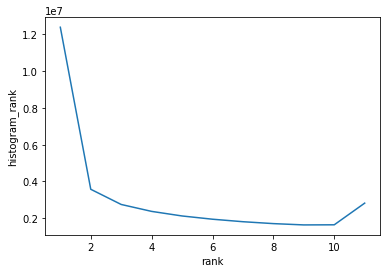

In [29]:
xs.rank_histogram(mrms_pert.chunk({'valid_time': 1}), interp_pert.chunk({'valid_time': 1})).compute().plot()

In [30]:
xs.crps_ensemble(mrms, interp)

<xarray.DataArray ()>
array(0.3749019)
Coordinates:
    time       datetime64[ns] 2020-05-16
    lead_time  timedelta64[ns] 12:00:00
    variable   <U2 'tp'

## HRRR

In [ ]:
!ls /datadrive_ssd/